## gekoppelte Pendel

In [385]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


In [324]:
tt = []
xx1 = []; xx2 = []
TT = [];
for i in range(1, 4+1):
    txt = loadtxt(f'punkte_loch{i}_schwebung.txt', skiprows=5, delimiter='\t')
    t_, x1_, x2_ = transpose(txt)
    T_ = t_[-1]
    tt.append(t_)
    xx1.append(x1_); xx2.append(x2_)
    TT.append(T_)

vals = list(zip(tt, xx1, xx2, TT))

In [325]:
t, x1, x2, TT = vals[1 - 1]

In [326]:
print(2*pi/t[-1])

0.04195783176747637


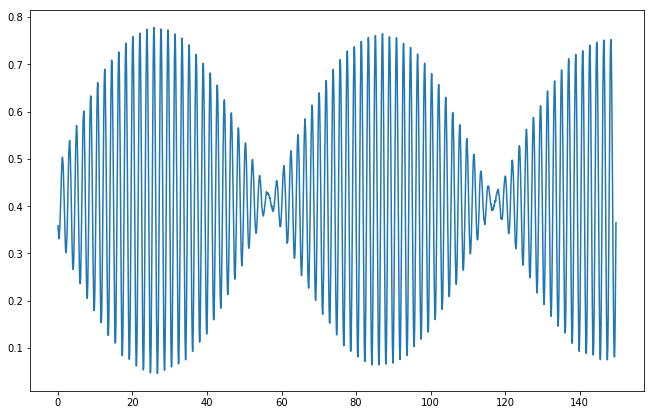

In [327]:
plt.plot(t, x1)

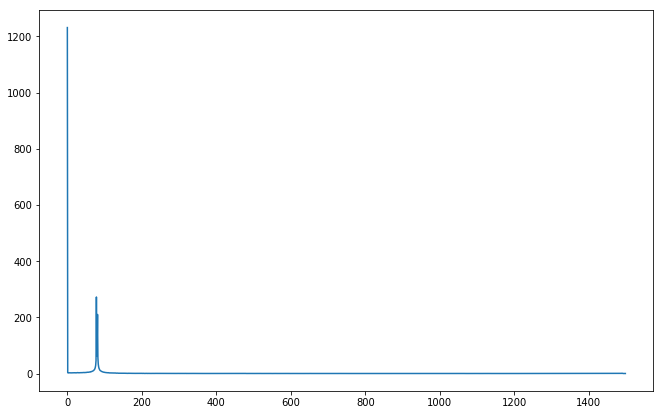

In [328]:
freq = fft.rfft(x1)
plt.plot(abs(freq))

In [329]:
n1, n2 = argpartition(-abs(freq), 2)[1:3]
print(n1, n2)

78 81


In [330]:
w1 = 2*pi/t[-1] * n1; w2 = 2*pi/t[-1] * n2
A1 = .9* sqrt(2*pi) * abs(freq[n1])/len(x1); phi1 = angle(freq[n1])
A2 = .9* sqrt(2*pi) * abs(freq[n2])/len(x1); phi2 = angle(freq[n2])

In [331]:
w1, A1, phi1
w2, A2, phi2
A = .5*(A1 + A2)

(3.272710877863157, 0.20507666878825395, -2.306812582010354)

(3.398584373165586, 0.15825910464603182, -0.21815113075974646)

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


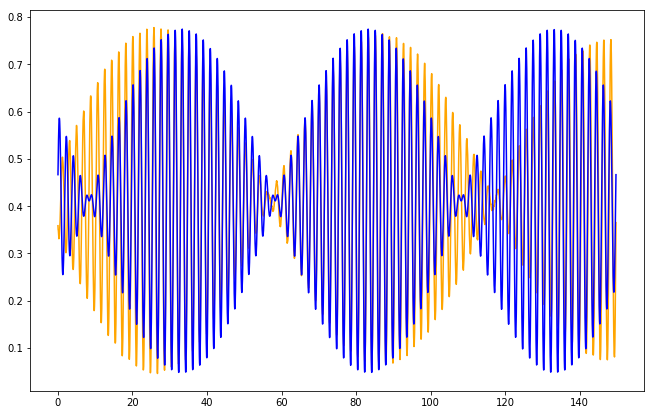

In [332]:
# _p1[0].remove(); _p2[0].remove()
_p1 = plt.plot(t, x1, 'orange')
_p2 = plt.plot(t, A * cos(w1*t + phi1) + A * cos(w2*t + phi2) + freq[0]/len(x1), 'blue')

In [333]:
2*pi/t[-1]

0.04195783176747637

In [334]:
def link(t, w1, w2, A1, A2, phi1, phi2):
    """Linearkombination von 2 Eigenmoden"""
    return A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)

def glink(t, w1, w2, A, phi1, phi2):
    """Schwebung als Linearkobination mit gleichem Koeffizient für beide Eigenmoden"""
    return A* (cos(w1*t + phi1) + cos(w2*t + phi2))

def linkd(t, w1, w2, A1, A2, phi1, phi2, g):
    """Linearkombination mit Dämpfung: exponentieller Abfall"""
    return (A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)) * exp(-g*t)

def linkd2(t, w1, w2, A1, A2, phi1, phi2, g):
    """Linearkombination mit Dämpfung: Dämpfung hängt von Geschwindigkeit ab
    (gedämpfter Oszillator)"""
    return A1*cos(w1*t + phi1)*exp(-g*w1*t) + A2*cos(w2*t + phi2)*exp(-g*w2*t)

def schweb(t, wi, wa, B, phii, phia):
    """Schwebung durch einhüllende Welle und schmelle Oszillation.
    Mathematisch äquivalent zu `glink`"""
    return B * cos(wa*t + phia) * cos(wi*t + phii)

In [335]:
a1 = x1 - mean(x1)

### fitten Schwebung direkt

In [348]:
wa = (w1 - w2)/2; wi = (w1 + w2)/2
p0 = [(w1 - w2)/2, (w1 + w2)/2, 2*A, (phi1 - phi2)/2, (phi1 + phi2)/2]
popt, pcov = scipy.optimize.curve_fit(schweb, t, a1, p0=p0,
                                      maxfev=300)

wi_, wa_, B_, phii_, phia_ = popt
err_wi, err_wa, err_B, err_phii, err_phia = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - p0

-0.05181822567174059 +- 5.113718651369214e-10
3.3307604079437607 +- 4.052909117643002e-10
0.35330198007074126 +- 1.0321361592577832e-07
-1.7763565970145754 +- 3.725405593681924e-06
-0.9688915047046498 +- 3.106334525957005e-06


array([ 0.01111852, -0.00488722, -0.01003379, -0.73202587,  0.29359035])

chi^2: 0.4867575614469705


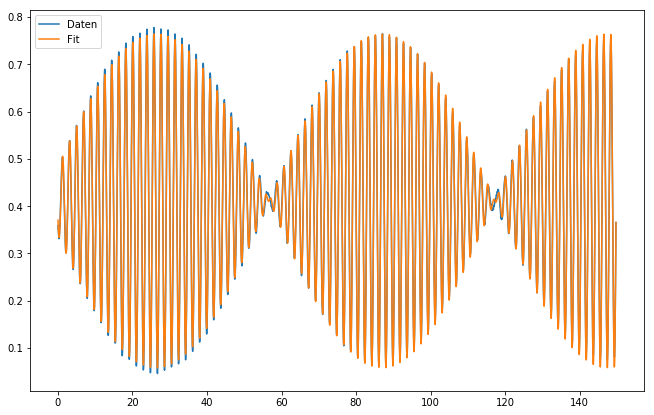

In [337]:
_ = plt.plot(t, x1)
fit = vectorize(schweb)(t, wi_, wa_, B_, phii_, phia_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten Summe der Eigenmoden

In [347]:
popt, pcov = scipy.optimize.curve_fit(glink, t, a1, p0=[w1, w2, A, phi1, phi2],
                                      maxfev=200)
w1_, w2_, A_, phi1_, phi2_ = popt
err_w1, err_w2, err_A, err_phi1, err_phi2 = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - [w1, w2, A, phi1, phi2]

3.2789421779886556 +- 9.17803896496838e-10
3.3825786382365113 +- 9.155242799550605e-10
0.1766509899906484 +- 2.5803404158739314e-08
-2.745247787277974 +- 6.837757101353956e-06
0.807464754712672 +- 6.825727858820844e-06


array([ 0.0062313 , -0.01600573, -0.0050169 , -0.43843521,  1.02561589])

chi^2: 0.4867575614471959


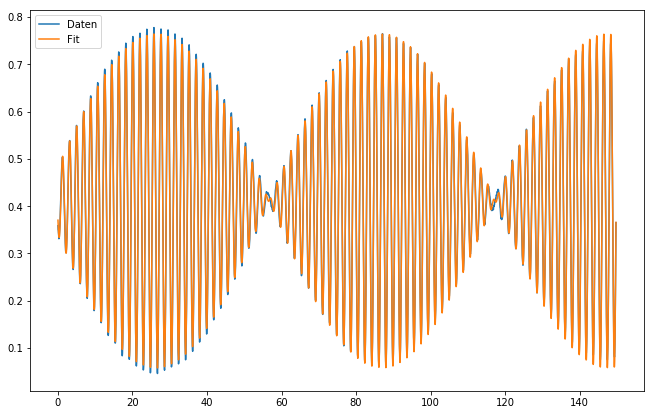

In [339]:
_ = plt.plot(t, x1)
fit = vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1))
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten linearkombination der Eigenmoden

In [346]:
popt, pcov = scipy.optimize.curve_fit(link, t, a1, p0=[w1, w2, A1, A2, phi1, phi2],
                                      maxfev=100)
w1_, w2_, A1_, A2_, phi1_, phi2_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2 = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - [w1, w2, A1, A2, phi1, phi2]

3.2789404078962505 +- 3.190528003172391e-10
3.38257989493857 +- 3.7487208314770366e-10
0.18387577333789085 +- 2.0255363158679905e-08
0.16942276098067713 +- 2.027659165928126e-08
-2.7496778172064604 +- 2.3812490317524772e-06
0.8023489400981432 +- 2.8006305940047376e-06


array([ 0.00622953, -0.01600448, -0.0212009 ,  0.01116366, -0.44286524,
        1.02050007])

chi^2: 0.29867787483532976


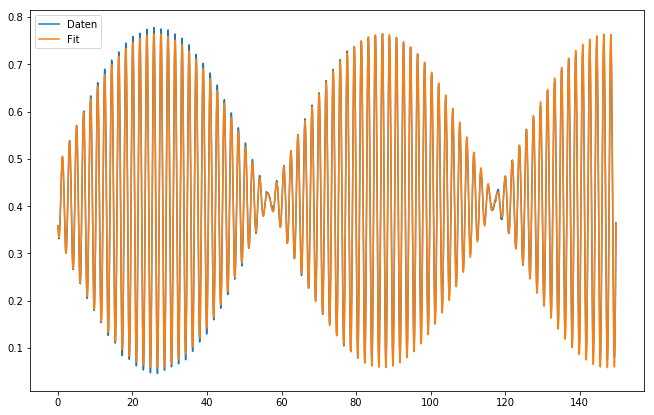

In [341]:
_ = plt.plot(t, x1)
fit = vectorize(link)(t, w1_, w2_, A1_, A2_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### because we can: Linearkombination mit Dämpfung

3.2786903089113 +- 6.92e-11
3.382860937778 +- 8.18e-11
0.19301552788055 +- 1.16e-08
0.17786725036378 +- 1.06e-08
-2.7312128754732 +- 4.84e-07
0.78145929607873 +- 5.73e-07
0.00064882359770939 +- 3.57e-11

Differenzen: [ 0.00597943 -0.01572344 -0.01206114  0.01960815 -0.42440029  0.99961043
 -0.99935118]

chi^2: 0.1339511611464441


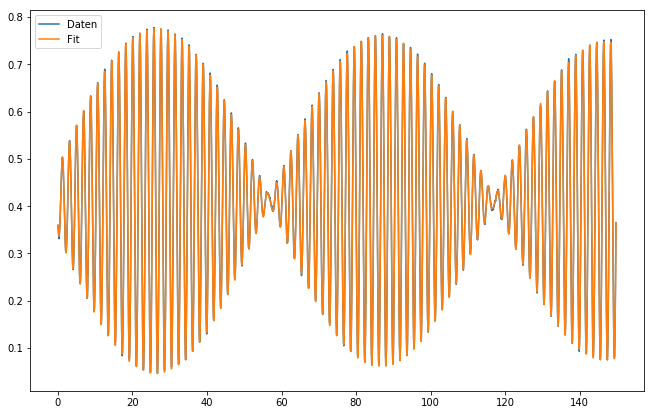

In [431]:
popt, pcov = scipy.optimize.curve_fit(linkd, t, a1, p0=[w1, w2, A1, A2, phi1, phi2, 0],
                                      maxfev=100)
w1_, w2_, A1_, A2_, phi1_, phi2_, g_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2, err_g = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v:.14} +- {err:.3}')
print()
print('Differenzen:', popt - [w1, w2, A1, A2, phi1, phi2, 1])

_ = plt.plot(t, x1)
fit = vectorize(linkd)(t, w1_, w2_, A1_, A2_, phi1_, phi2_, g_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print()
print('chi^2:', norm(x1 - fit))